# Field Validation

In [2]:

import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.Preprocessing import *
from utils.Segmentation import *


In [3]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')
df

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,0,2025-03-28 16:22:59.826,2025-03-28 16:23:00.318,7.527374,7.082046,7.699753,8.097183,3.246536,10.180145,6.402100,...,8.264786,8.092407,8.743622,8.820236,8.465897,7.723694,7.182602,7.675812,8.078033,7.618347
2682,0,2025-03-28 16:23:00.324,2025-03-28 16:23:00.815,6.919251,7.096420,8.125916,8.643066,8.264786,7.790726,7.967911,...,7.843399,7.881714,7.987061,7.958328,7.948746,7.920013,7.872131,8.015793,8.135498,7.929596
2683,0,2025-03-28 16:23:00.821,2025-03-28 16:23:01.311,7.881714,7.838623,7.996628,8.011002,7.862564,7.833832,7.852982,...,7.833832,7.690170,7.733276,7.819458,7.800308,7.675812,7.551315,7.623138,7.704544,7.704544
2684,0,2025-03-28 16:23:01.319,2025-03-28 16:23:01.811,7.580048,7.465118,7.575256,7.637497,7.685394,7.450760,7.489059,...,7.733276,7.776367,7.642288,7.556107,7.642288,7.704544,7.690170,7.608780,7.575256,7.632721


In [5]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Extract features (remove curb_scene, start_time, and end_time columns)
x_test = test_data_scaled.iloc[:, :-3]
y_true = test_data_scaled['curb_scene'].values
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)



In [6]:
def evaluate_classification(y_true, y_pred):
    """
    Evaluate binary classification results and display metrics and visualizations
    
    Parameters:
        y_true (array-like): Ground truth labels
        y_pred (array-like): Predicted labels
        
    Returns:
        dict: Dictionary containing the metrics (confusion matrix, accuracy, specificity, sensitivity)
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Generate detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Calculate additional metrics
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
    
    print("\nAdditional Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Specificity: {specificity:.3f}")  
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add text annotations
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
    
    return {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'specificity': specificity,
        'sensitivity': sensitivity
    }


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      2456
           1       0.44      0.85      0.58       230

    accuracy                           0.89      2686
   macro avg       0.71      0.87      0.76      2686
weighted avg       0.94      0.89      0.91      2686


Additional Metrics:
Accuracy: 0.894
Specificity: 0.899
Sensitivity (Recall): 0.848


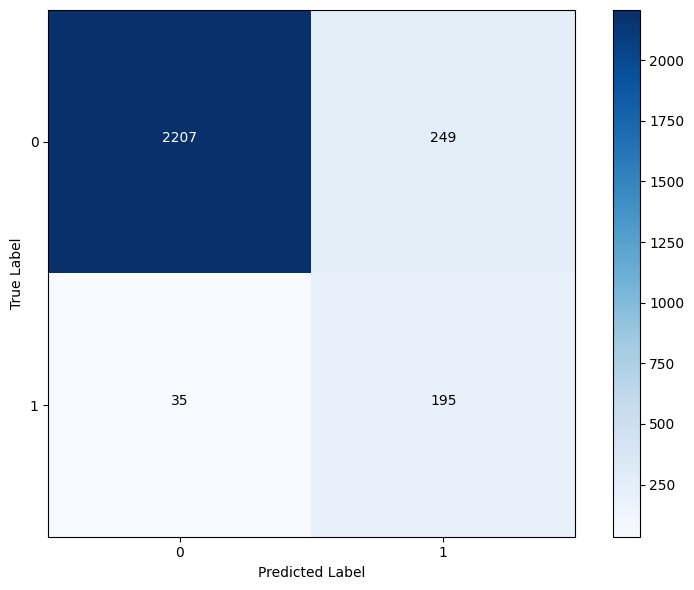

In [7]:
# Make predictions using one-class SVM
one_class_svm = joblib.load('../../models/ocsvm_best.joblib')
y_pred = one_class_svm.predict(x_test)
# Convert predictions to binary (1 for anomaly, 0 for normal)
y_pred = np.where(y_pred == -1, 1, 0)
# Evaluate results
metrics = evaluate_classification(y_true, y_pred)

